<a href="https://colab.research.google.com/github/itzrnvr/deeplearning-lab/blob/main/assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Optimizers, Regularization, and Pretrained Models

In [2]:
# Initial Setup: Import Libraries and Set Seeds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, VGG19, ResNet50
# Note: AlexNet is not available in keras.applications. To use AlexNet, you may need to implement it from scratch or use a third-party repository.
from tensorflow.keras.datasets import cifar10, cifar100, mnist, fashion_mnist

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Part 1: Implementing Momentum, RMSProp, Adam Optimizer and Demonstrating Overfitting and Regularization Techniques: L1, L2, Dropout

### Part 1A: Neural Network with Iris Dataset and Regularization Techniques

#### 1. Load and Prepare Iris Dataset

In [4]:
# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# One-hot encode target
y_cat = to_categorical(y)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_cat, test_size=0.2, random_state=42, stratify=y)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (120, 4)
X_test shape: (30, 4)
y_train shape: (120, 3)
y_test shape: (30, 3)


#### 2.1 Model without Regularization

In [5]:
def build_model(input_shape, num_classes, l1_reg=0.0, l2_reg=0.0, include_dropout=False, dropout_rate=0.0):
    model = Sequential()
    # Input layer
    model.add(Dense(32, activation='tanh', input_shape=input_shape,
                    kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    # Hidden layer 1
    model.add(Dense(32, activation='tanh',
                    kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    if include_dropout and dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    # Hidden layer 2
    model.add(Dense(32, activation='tanh',
                    kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    if include_dropout and dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    # Hidden layer 3
    model.add(Dense(16, activation='relu',
                    kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    if include_dropout and dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model without regularization
model_no_reg = build_model(input_shape=(X_train.shape[1],), num_classes=y_train.shape[1])
model_no_reg.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,851 (11.14 KB)

 Trainable params: 2,851 (11.14 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train model without regularization
history_no_reg = model_no_reg.fit(
    X_train, y_train,
    epochs=200,
    batch_size=512,
    validation_data=(X_test, y_test),
    verbose=0
)

# Evaluate
loss_no_reg, acc_no_reg = model_no_reg.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss_no_reg:.4f}, Test Accuracy: {acc_no_reg:.4f}")

Test Loss: 0.0762, Test Accuracy: 0.9667


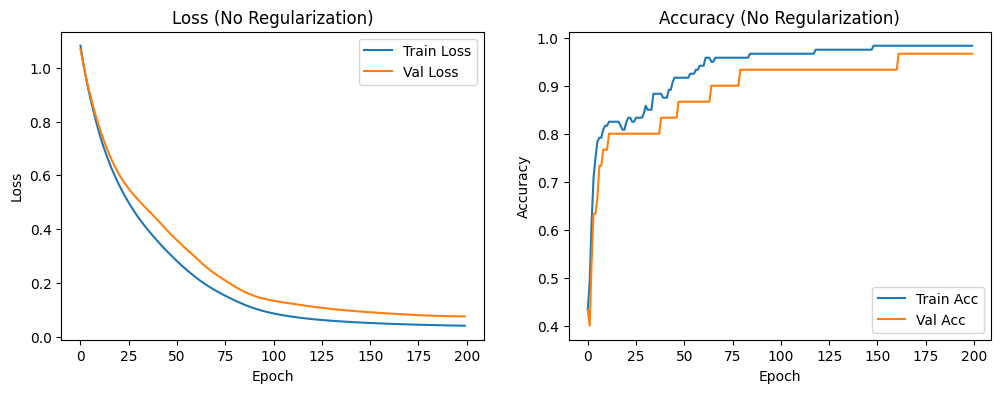

In [7]:
# Plot loss and accuracy for model without regularization
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(history_no_reg.history['loss'], label='Train Loss')
axs[0].plot(history_no_reg.history['val_loss'], label='Val Loss')
axs[0].set_title('Loss (No Regularization)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(history_no_reg.history['accuracy'], label='Train Acc')
axs[1].plot(history_no_reg.history['val_accuracy'], label='Val Acc')
axs[1].set_title('Accuracy (No Regularization)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.show()

#### 2.2 Model with L1 Regularization

In [8]:
# Model with L1 regularization
model_l1 = build_model(input_shape=(X_train.shape[1],), num_classes=y_train.shape[1], l1_reg=0.01)
model_l1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,851 (11.14 KB)

 Trainable params: 2,851 (11.14 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train model with L1 regularization
history_l1 = model_l1.fit(
    X_train, y_train,
    epochs=200,
    batch_size=512,
    validation_data=(X_test, y_test),
    verbose=0
)

# Evaluate
loss_l1, acc_l1 = model_l1.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss_l1:.4f}, Test Accuracy: {acc_l1:.4f}")

Test Loss: 1.5050, Test Accuracy: 0.9667


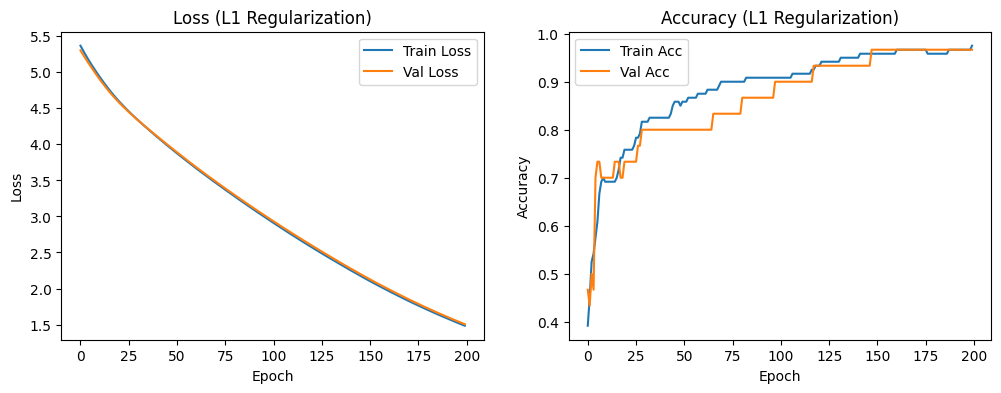

In [10]:
# Plot loss and accuracy for model with L1 regularization
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(history_l1.history['loss'], label='Train Loss')
axs[0].plot(history_l1.history['val_loss'], label='Val Loss')
axs[0].set_title('Loss (L1 Regularization)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(history_l1.history['accuracy'], label='Train Acc')
axs[1].plot(history_l1.history['val_accuracy'], label='Val Acc')
axs[1].set_title('Accuracy (L1 Regularization)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.show()

#### 2.3 Model with L2 Regularization

In [11]:
# Model with L2 regularization
model_l2 = build_model(input_shape=(X_train.shape[1],), num_classes=y_train.shape[1], l2_reg=0.01)
model_l2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,851 (11.14 KB)

 Trainable params: 2,851 (11.14 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train model with L2 regularization
history_l2 = model_l2.fit(
    X_train, y_train,
    epochs=200,
    batch_size=512,
    validation_data=(X_test, y_test),
    verbose=0
)

# Evaluate
loss_l2, acc_l2 = model_l2.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss_l2:.4f}, Test Accuracy: {acc_l2:.4f}")

Test Loss: 0.5230, Test Accuracy: 0.9667


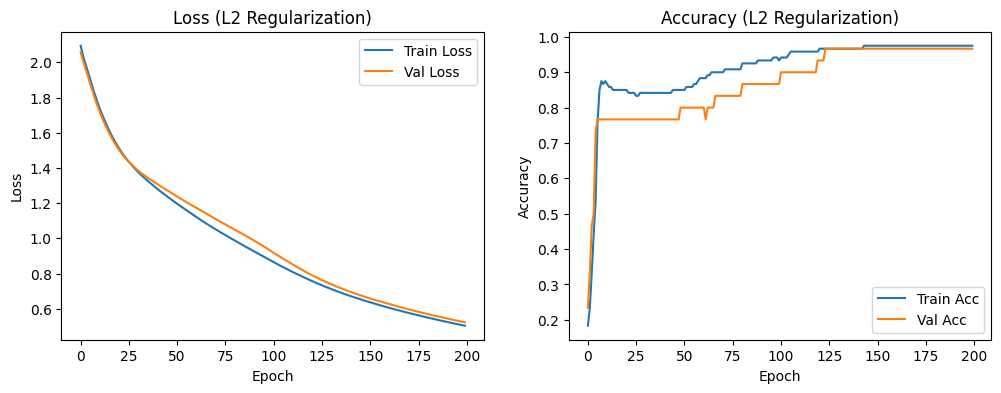

In [13]:
# Plot loss and accuracy for model with L2 regularization
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(history_l2.history['loss'], label='Train Loss')
axs[0].plot(history_l2.history['val_loss'], label='Val Loss')
axs[0].set_title('Loss (L2 Regularization)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(history_l2.history['accuracy'], label='Train Acc')
axs[1].plot(history_l2.history['val_accuracy'], label='Val Acc')
axs[1].set_title('Accuracy (L2 Regularization)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.show()

#### 2.4 Model with Dropout

In [14]:
# Model with Dropout
model_dropout = build_model(input_shape=(X_train.shape[1],), num_classes=y_train.shape[1], include_dropout=True, dropout_rate=0.2)
model_dropout.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,851 (11.14 KB)

 Trainable params: 2,851 (11.14 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train model with Dropout
history_dropout = model_dropout.fit(
    X_train, y_train,
    epochs=200,
    batch_size=512,
    validation_data=(X_test, y_test),
    verbose=0
)

# Evaluate
loss_dropout, acc_dropout = model_dropout.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss_dropout:.4f}, Test Accuracy: {acc_dropout:.4f}")

Test Loss: 0.0892, Test Accuracy: 0.9333


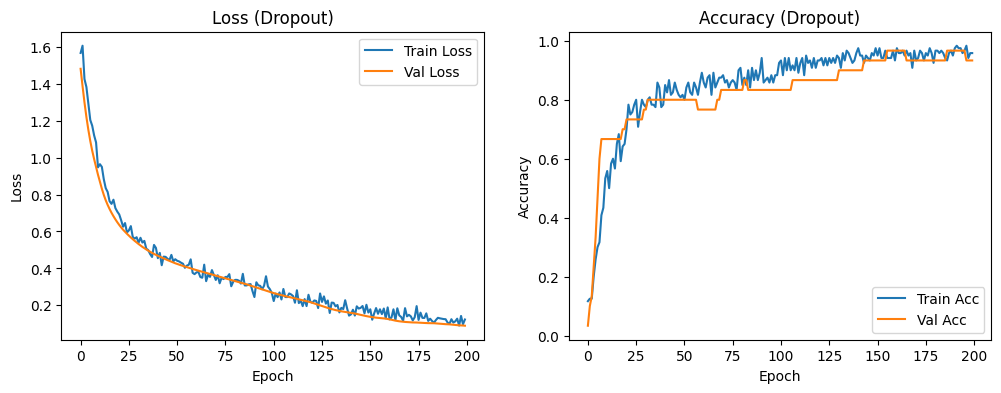

In [16]:
# Plot loss and accuracy for model with Dropout
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(history_dropout.history['loss'], label='Train Loss')
axs[0].plot(history_dropout.history['val_loss'], label='Val Loss')
axs[0].set_title('Loss (Dropout)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(history_dropout.history['accuracy'], label='Train Acc')
axs[1].plot(history_dropout.history['val_accuracy'], label='Val Acc')
axs[1].set_title('Accuracy (Dropout)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.show()

#### 6. Comparison of Regularization Techniques

The table below summarizes the test accuracy and loss for each model. From the plots, observe the effect of each regularization technique on overfitting and generalization.

In [17]:
results = pd.DataFrame({
    'Model': ['No Regularization', 'L1', 'L2', 'Dropout'],
    'Test Loss': [loss_no_reg, loss_l1, loss_l2, loss_dropout],
    'Test Accuracy': [acc_no_reg, acc_l1, acc_l2, acc_dropout]
})
results

,Model,Test Loss,Test Accuracy
0,No Regularization,0.076179,0.966667
1,L1,1.505044,0.966667
2,L2,0.522986,0.966667
3,Dropout,0.089233,0.933333


### Part 1B: Implementing Optimizers from Scratch

#### 1. Define Loss Function and its Derivative

We use $f(m) = m^2 - 2m + 1$ and its derivative $f'(m) = 2m - 2$.

In [18]:
def f(m):
    return m**2 - 2*m + 1

def f_prime(m):
    return 2*m - 2

#### 2. Initialize Parameters

In [19]:
# Common hyperparameters
alpha = 0.1  # learning rate
beta1 = 0.9  # for momentum/adam
beta2 = 0.999  # for RMSProp/adam
epsilon = 1e-8
epsilon_conv = 1e-6
max_iters = 1000

# For fair comparison, fix the random seed and initial w
np.random.seed(42)
w_init = np.random.randn()

#### Momentum Optimizer (Scratch)

In [20]:
w_mom = w_init
v = 0
mom_ws = [w_mom]
mom_losses = [f(w_mom)]
for t in range(1, max_iters+1):
    grad = f_prime(w_mom)
    v = beta1 * v + alpha * grad
    w_new = w_mom - v
    mom_ws.append(w_new)
    mom_losses.append(f(w_new))
    if abs(w_new - w_mom) < epsilon_conv:
        break
    w_mom = w_new
print(f"Momentum converged in {t} iterations. Final w: {w_mom:.6f}, Final loss: {f(w_mom):.6e}")

Momentum converged in 157 iterations. Final w: 1.000128, Final loss: 1.645863e-08


#### RMSProp Optimizer (Scratch)

In [21]:
w_rms = w_init
s = 0
rms_ws = [w_rms]
rms_losses = [f(w_rms)]
for t in range(1, max_iters+1):
    grad = f_prime(w_rms)
    s = beta2 * s + (1 - beta2) * grad**2
    s_hat = s / (1 - beta2**t)  # bias correction
    w_new = w_rms - (alpha / (np.sqrt(s_hat) + epsilon)) * grad
    rms_ws.append(w_new)
    rms_losses.append(f(w_new))
    if abs(w_new - w_rms) < epsilon_conv:
        break
    w_rms = w_new
print(f"RMSProp converged in {t} iterations. Final w: {w_rms:.6f}, Final loss: {f(w_rms):.6e}")

RMSProp converged in 24 iterations. Final w: 0.999999, Final loss: 9.281464e-13


#### Adam Optimizer (Scratch)

In [22]:
w_adam = w_init
m = 0
v = 0
adam_ws = [w_adam]
adam_losses = [f(w_adam)]
for t in range(1, max_iters+1):
    grad = f_prime(w_adam)
    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * grad**2
    m_hat = m / (1 - beta1**t)
    v_hat = v / (1 - beta2**t)
    w_new = w_adam - (alpha / (np.sqrt(v_hat) + epsilon)) * m_hat
    adam_ws.append(w_new)
    adam_losses.append(f(w_new))
    if abs(w_new - w_adam) < epsilon_conv:
        break
    w_adam = w_new
print(f"Adam converged in {t} iterations. Final w: {w_adam:.6f}, Final loss: {f(w_adam):.6e}")

Adam converged in 202 iterations. Final w: 1.000011, Final loss: 1.202398e-10


#### 4. Plot Loss vs. Epoch for Optimizers

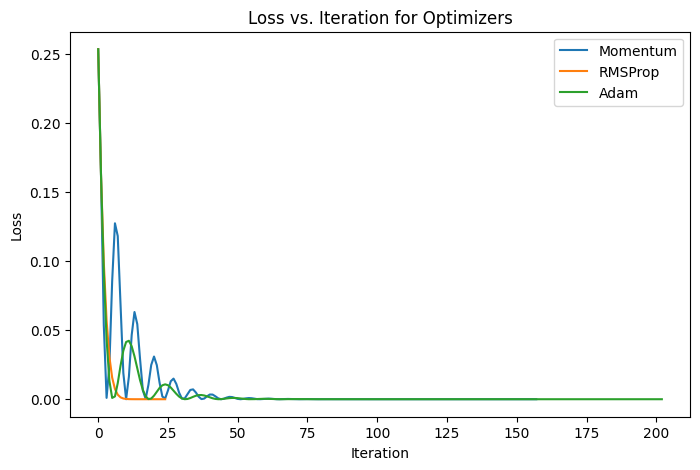

In [23]:
plt.figure(figsize=(8,5))
plt.plot(mom_losses, label='Momentum')
plt.plot(rms_losses, label='RMSProp')
plt.plot(adam_losses, label='Adam')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Iteration for Optimizers')
plt.legend()
plt.show()

#### 5. Compare Optimizers

In [24]:
optimizer_results = pd.DataFrame({
    'Optimizer': ['Momentum', 'RMSProp', 'Adam'],
    'Iterations': [len(mom_losses)-1, len(rms_losses)-1, len(adam_losses)-1],
    'Final Loss': [mom_losses[-1], rms_losses[-1], adam_losses[-1]],
    'Final w': [mom_ws[-1], rms_ws[-1], adam_ws[-1]]
})
optimizer_results

,Optimizer,Iterations,Final Loss,Final w
0,Momentum,157,1.662416e-08,1.000129
1,RMSProp,24,1.342260e-13,1.000000
2,Adam,202,1.330678e-10,1.000012


From the table above, we see the number of iterations to converge, final loss, and final $w$ for each optimizer. All optimizers should converge to $w=1$ for $f(m)=(m-1)^2$. Adam typically converges fastest, followed by RMSProp and Momentum for this simple problem.

## Part 2: Implementation and Customization of Pre-trained Models

### 1. Dataset and Pre-trained Model Selection

- **Dataset:** Fashion MNIST
- **Pre-trained Model:** VGG16

Fashion MNIST images are 28x28 grayscale. VGG16 expects 3-channel images and a minimum input size (e.g., 32x32 or 48x48). We will resize to 48x48 and convert to 3 channels.

### 2. Load and Preprocess Data

In [25]:
# Load Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Resize to 48x48 and convert to 3 channels
x_train_resized = tf.image.resize(x_train[..., np.newaxis], [48, 48]).numpy()
x_test_resized = tf.image.resize(x_test[..., np.newaxis], [48, 48]).numpy()
x_train_rgb = np.concatenate([x_train_resized]*3, axis=-1)
x_test_rgb = np.concatenate([x_test_resized]*3, axis=-1)

# One-hot encode labels
y_train_one_hot = to_categorical(y_train, num_classes=10)
y_test_one_hot = to_categorical(y_test, num_classes=10)

print('x_train_rgb shape:', x_train_rgb.shape)
print('x_test_rgb shape:', x_test_rgb.shape)
print('y_train_one_hot shape:', y_train_one_hot.shape)
print('y_test_one_hot shape:', y_test_one_hot.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train_rgb shape: (60000, 48, 48, 3)
x_test_rgb shape: (10000, 48, 48, 3)
y_train_one_hot shape: (60000, 10)
y_test_one_hot shape: (10000, 10)


### 3.1 Using VGG16 as a Feature Extractor

In [26]:
# Load VGG16 base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
base_model.trainable = False

# Build model
model_fe = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])
model_fe.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model_fe.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [27]:
# Train feature extractor model
history_fe = model_fe.fit(
    x_train_rgb, y_train_one_hot,
    epochs=10,
    batch_size=128,
    validation_data=(x_test_rgb, y_test_one_hot),
    verbose=1
)

# Evaluate
loss_fe, acc_fe = model_fe.evaluate(x_test_rgb, y_test_one_hot, verbose=0)
print(f"Test Loss: {loss_fe:.4f}, Test Accuracy: {acc_fe:.4f}")

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 71ms/step - accuracy: 0.6782 - loss: 0.9463 - val_accuracy: 0.8310 - val_loss: 0.4618
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - accuracy: 0.8323 - loss: 0.4668 - val_accuracy: 0.8497 - val_loss: 0.4132
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.8485 - loss: 0.4180 - val_accuracy: 0.8604 - val_loss: 0.3897
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.8574 - loss: 0.3919 - val_accuracy: 0.8649 - val_loss: 0.3767
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.8626 - loss: 0.3757 - val_accuracy: 0.8667 - val_loss: 0.3678
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.8671 - loss: 0.3639 - val_accuracy: 0.8693 - val_loss: 0.3615
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - accuracy: 0.8711 - loss: 0.3495 - val_accuracy: 0.8694 - val_loss: 0.3573
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 54ms/step - accuracy: 0.8746 - loss: 0.3422 - 

In [28]:
import time
# Measure inference time (ms/image)
n_samples = 100
x_test_batch = x_test_rgb[:n_samples]
start_time = time.time()
model_fe.predict(x_test_batch, verbose=0)
end_time = time.time()
inference_time_fe = (end_time - start_time) / n_samples * 1000  # ms per image
print(f"Inference time (ms/image): {inference_time_fe:.4f}")

Inference time (ms/image): 25.9386


In [29]:
# FLOPs calculation (optional, may not work in Colab)
try:
    # !pip install tf-flops  # Uncomment if running in Colab
    from tf_flops import get_flops
    flops_fe = get_flops(model_fe, batch_size=1)
    print(f"FLOPs: {flops_fe}")
except Exception as e:
    print("FLOPs calculation not available in this environment.")

FLOPs calculation not available in this environment.


### 3.2 Fine-tuning VGG16

In [30]:
# Unfreeze block5_conv1 and onwards
base_model.trainable = True
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    layer.trainable = set_trainable

# Re-compile with lower learning rate
model_fe.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model_fe.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 7,213,322 (27.52 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [31]:
# Fine-tune for a few more epochs
history_ft = model_fe.fit(
    x_train_rgb, y_train_one_hot,
    epochs=5,
    batch_size=128,
    validation_data=(x_test_rgb, y_test_one_hot),
    verbose=1
)

# Evaluate
loss_ft, acc_ft = model_fe.evaluate(x_test_rgb, y_test_one_hot, verbose=0)
print(f"Test Loss: {loss_ft:.4f}, Test Accuracy: {acc_ft:.4f}")

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 71ms/step - accuracy: 0.8874 - loss: 0.3055 - val_accuracy: 0.8929 - val_loss: 0.3001
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 60ms/step - accuracy: 0.9073 - loss: 0.2530 - val_accuracy: 0.8968 - val_loss: 0.2854
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 60ms/step - accuracy: 0.9153 - loss: 0.2250 - val_accuracy: 0.9032 - val_loss: 0.2781
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.9246 - loss: 0.2016 - val_accuracy: 0.9041 - val_loss: 0.2679
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.9318 - loss: 0.1828 - val_accuracy: 0.9056 - val_loss: 0.2708
Test Loss: 0.2708, Test Accuracy: 0.9056


In [32]:
# Inference time for fine-tuned model (should be similar)
start_time = time.time()
model_fe.predict(x_test_batch, verbose=0)
end_time = time.time()
inference_time_ft = (end_time - start_time) / n_samples * 1000  # ms per image
print(f"Inference time (ms/image): {inference_time_ft:.4f}")

Inference time (ms/image): 13.2139


### 3.3 Comparison of Pre-trained Model Approaches

In [33]:
comparison_df = pd.DataFrame({
    'Model': ['VGG16 Feature Extractor', 'VGG16 Fine-Tuned'],
    'Test Accuracy': [acc_fe, acc_ft],
    'Inference Time (ms/image)': [inference_time_fe, inference_time_ft],
    'FLOPs': ['See above', 'See above']
})
comparison_df

,Model,Test Accuracy,Inference Time (ms/image),FLOPs
0,VGG16 Feature Extractor,0.8784,25.938568,See above
1,VGG16 Fine-Tuned,0.9056,13.213892,See above


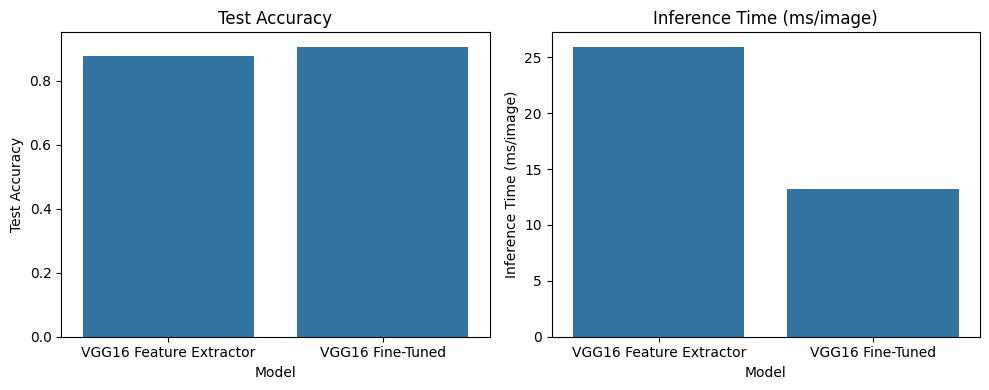

In [34]:
# Plot bar charts for accuracy and inference time
fig, axs = plt.subplots(1, 2, figsize=(10,4))
sns.barplot(x='Model', y='Test Accuracy', data=comparison_df, ax=axs[0])
axs[0].set_title('Test Accuracy')
sns.barplot(x='Model', y='Inference Time (ms/image)', data=comparison_df, ax=axs[1])
axs[1].set_title('Inference Time (ms/image)')
plt.tight_layout()
plt.show()

### 6. Conclusion for Part 2

- VGG16 as a feature extractor provides a strong baseline for Fashion MNIST classification.
- Fine-tuning the top layers of VGG16 can further improve accuracy, though gains may be modest for simple datasets.
- Inference time and FLOPs remain similar, as the architecture is unchanged.
- FLOPs calculation may require additional packages and may not always be available in Colab.
- AlexNet is not available in keras.applications; to use it, consider third-party implementations or build from scratch.

# End of Assignment 2.